# CRUD operations

1: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

In [1]:
import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (n:Superhero)
WHERE (n.Speed) IS NOT NULL
RETURN n.name, n.Speed
ORDER BY n.Speed DESC
LIMIT 10"""

results = graph.run(query)

for record in results:
    print(record)

'Black Bolt'	100
'Stardust'	100
'Quicksilver'	100
'Nova'	100
'Thor'	92
'Silver Surfer'	84
'Galactus'	83
'Dormammu'	83
'Ego'	83
'Northstar'	83


In [2]:
# Relations entre les super-héros
import py2neo
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")

query = """MATCH (n:Superhero)-[r]-(m:Superhero)
WHERE n.name IN ['Black Bolt', 'Stardust', 'Quicksilver', 'Nova', 'Thor', 'Silver Surfer', 'Galactus', 'Dormammu', 'Ego', 'Northstar']
AND m.name IN ['Black Bolt', 'Stardust', 'Quicksilver', 'Nova', 'Thor', 'Silver Surfer', 'Galactus', 'Dormammu', 'Ego', 'Northstar']
RETURN n.name, m.name"""

results = graph.run(query)

for record in results:
    print(record)

'Ego'	'Galactus'
'Dormammu'	'Galactus'
'Black Bolt'	'Galactus'
'Northstar'	'Galactus'
'Nova'	'Galactus'
'Stardust'	'Galactus'
'Silver Surfer'	'Galactus'
'Quicksilver'	'Galactus'
'Thor'	'Galactus'
'Ego'	'Silver Surfer'
'Nova'	'Silver Surfer'
'Quicksilver'	'Silver Surfer'
'Black Bolt'	'Silver Surfer'
'Galactus'	'Silver Surfer'
'Dormammu'	'Silver Surfer'
'Stardust'	'Silver Surfer'
'Thor'	'Silver Surfer'
'Northstar'	'Thor'
'Ego'	'Thor'
'Silver Surfer'	'Thor'
'Nova'	'Thor'
'Black Bolt'	'Thor'
'Galactus'	'Thor'
'Quicksilver'	'Thor'
'Dormammu'	'Thor'
'Dormammu'	'Quicksilver'
'Ego'	'Quicksilver'
'Nova'	'Quicksilver'
'Galactus'	'Quicksilver'
'Black Bolt'	'Quicksilver'
'Northstar'	'Quicksilver'
'Silver Surfer'	'Quicksilver'
'Thor'	'Quicksilver'
'Quicksilver'	'Dormammu'
'Galactus'	'Dormammu'
'Thor'	'Dormammu'
'Silver Surfer'	'Dormammu'
'Galactus'	'Ego'
'Thor'	'Ego'
'Nova'	'Ego'
'Silver Surfer'	'Ego'
'Quicksilver'	'Ego'
'Black Bolt'	'Nova'
'Ego'	'Nova'
'Galactus'	'Nova'
'Silver Surfer'	'Nova'
'Qui

2: How many have collaborated atleast more than 10 times with another superhero?

In [3]:
query = """MATCH (a:Superhero)-[r:RELATION]-(b:Superhero)
WHERE r.n_collab >= 10
WITH a
MATCH (a)-[r:RELATION]-(b:Superhero)
WHERE r.n_collab >= 10
RETURN COUNT(DISTINCT a)"""

result = graph.run(query).evaluate()
print(f"{result} super héros ont collaboré plus de 10 fois avec un autre super héro")

565 super héros ont collaboré plus de 10 fois avec un autre super héro


3: Did the weakest of the MCU collaborated with the strongest ?

In [4]:
# Le plus faible
query_weakest = """MATCH (n:Superhero)
WHERE (n.Total) IS NOT NULL
RETURN n.name
ORDER BY n.Total
LIMIT 1"""
result_weakest = graph.run(query_weakest).evaluate()

# Le plus fort
query_strongest = """MATCH (n:Superhero)
WHERE (n.Total) IS NOT NULL
RETURN n.name
ORDER BY n.Total DESC
LIMIT 1"""
result_strongest = graph.run(query_strongest).evaluate()

# Chercher une éventuelle collaboration
query_relation = f"""MATCH (a:Superhero {{name: "{result_weakest}"}})-[r:RELATION]-(b:Superhero {{name: "{result_strongest}"}})
RETURN COUNT(r)"""
result_relation = graph.run(query_relation).evaluate()

if result_relation > 0:
    print(f"{result_weakest} a collaboré avec {result_strongest}")
else:
    print(f"{result_weakest} n'a pas collaboré avec {result_strongest}")

Lady Deathstrike n'a pas collaboré avec Stardust


4: Give a stats that interests you !
Cherchons les 10 meilleurs héros au combat.

In [5]:
query = """MATCH (n:Superhero)
WHERE (n.Combat) IS NOT NULL
RETURN n.name, n.Combat
ORDER BY n.Combat DESC
LIMIT 10"""

results = graph.run(query)

for record in results:
    print(record)

'Ares'	101
'Black Panther'	100
'Captain America'	100
'Sabretooth'	100
'Black Widow'	100
'Nick Fury'	100
'Deadpool'	100
'Punisher'	100
'Wolverine'	100
'Shang-Chi'	100


5: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

In [7]:
import random

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")

noms = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
personnes = [py2neo.Node("M1", name=nom, age=random.randint(20, 30)) for nom in noms]

for personne in personnes:
    graph.create(personne)

# Créer des groupes de 3 en supprimant à chaque fois les élèves dans les groupes formés (afin de ne pas avoir l'élève A dans 2 groupes)
groupes = []
while len(personnes) >= 3:
    groupe = random.sample(personnes, 3)
    groupes.append(groupe)
    for personne in groupe:
        personnes.remove(personne)

for groupe in groupes:
    for i, j in zip(groupe, groupe[1:] + [groupe[0]]):
        relation = py2neo.Relationship(i, "collab", j)
        graph.create(relation)

6: Get the age for people YOU collaborate with.

In [8]:
query = """MATCH (a:M1 {name:"A"})-[:collab]-(b:M1)
RETURN b.name, b.age"""

results = graph.run(query)
print(results)

 b.name | b.age 
--------|-------
 I      |    20 
 H      |    25 



7: Get nodes with age > 25.

In [9]:
query = """MATCH (a:M1)
WHERE a.age > 25
RETURN a.name, a.age"""

df = graph.run(query).to_data_frame()
print(df)

  a.name  a.age
0      A     30
1      C     29
2      E     28
3      G     27


# Real World Problem

8: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

In [15]:
import json
from py2neo import Graph, Node, Relationship

# Chemin vers le fichier JSON
json_file_path = "C:/Users/celes/OneDrive/Documents/M1/S2/Infrastructures/NoSQL/data/Chap2/data_world.json"

# Connexion à la base de données Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="arxiv")

# Charger les données JSON depuis le fichier
with open(json_file_path, "r") as file:
    data = json.load(file)

# Démarrer une transaction
tx = graph.begin()

# Parcourir les données pour créer le réseau de collaboration
for entry in data:
    # Vérifier si l'article a une année de publication
    if "year" in entry and entry["year"] > 2021:
        print(f"Processing entry: {entry['title']}")

        # Récupérer les auteurs de l'article s'ils existent
        if "authors" in entry:
            authors = entry["authors"]
            print(f"Authors: {authors}")

            # Créer des nœuds pour chaque auteur s'ils n'existent pas déjà
            author_nodes = {}
            for author in authors:
                if author not in author_nodes:
                    author_nodes[author] = Node("Author", name=author)
                    tx.merge(author_nodes[author], "Author", "name")
                    print(f"Node created for author: {author}")

            # Créer des relations de collaboration entre les auteurs
            for i, author1 in enumerate(authors):
                for j, author2 in enumerate(authors):
                    if i != j:
                        # Créer une relation de collaboration si elle n'existe pas déjà
                        if not graph.exists(Relationship(author_nodes[author1], "COLLAB", author_nodes[author2])):
                            tx.create(Relationship(author_nodes[author1], "COLLAB", author_nodes[author2]))
                            print(f"Collaboration relationship created between {author1} and {author2}")

# Valider la transaction (commit)
graph.commit(tx)

Collaboration network created and inserted into Neo4j.


9: Get the density of degrees of the collaboration network

In [17]:
from py2neo import Graph

# Connexion à la base de données Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="arxiv")

# Requête pour compter le nombre de nœuds et le nombre de relations
query = """
MATCH ()-[r:COLLAB]->()
WITH COUNT(DISTINCT r) AS num_edges

MATCH (a:Author)
RETURN COUNT(DISTINCT a) AS num_nodes, num_edges
"""

result = graph.run(query).data()[0]
num_nodes = result['num_nodes']
num_edges = result['num_edges']

# Calcul de la densité
density = (2 * num_edges) / (num_nodes * (num_nodes - 1))

print(f"The density of the collaboration network is: {density}")

IndexError: list index out of range

# Real World Application 3

1: Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

In [10]:
import json
from py2neo import Graph, Node, Relationship

# Chemin vers le fichier JSON
json_file_path = "C:/Users/celes/OneDrive/Documents/M1/S2/Infrastructures/NoSQL/data/Chap3/pubmed_cleaned/pubmed_cleaned.json"

# Connexion à la base de données Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="pubmedapp")

# Charger les données JSON depuis le fichier
with open(json_file_path, "r") as file:
    data = json.load(file)

# Dictionnaire pour stocker les auteurs uniques et leurs affiliations
authors_dict = {}

# Parcourir les données pour extraire les auteurs et les affiliations
for entry in data:
    # Séparer les noms des auteurs en utilisant le séparateur ","
    authors = entry.get("authors", "").split(", ")
    affiliations = entry.get("affiliations", "").split(", ")
    
    # Traiter chaque nom d'auteur individuellement
    for author, affiliation in zip(authors, affiliations):
        # Si l'auteur n'existe pas dans le dictionnaire, le rajouter avec ses affiliations
        if author not in authors_dict:
            authors_dict[author] = {"affiliations": [affiliation]}
        else:
            # Si l'auteur existe déjà, ajouter l'affiliation s'il n'est pas déjà dans la liste
            if affiliation not in authors_dict[author]["affiliations"]:
                authors_dict[author]["affiliations"].append(affiliation)

# Créer des nœuds pour chaque auteur avec une liste d'affiliations comme attribut
for author, data in authors_dict.items():
    node = Node("Author", name=author, affiliations=data["affiliations"])
    graph.merge(node, "Author", "name")

# Créer des relations entre les auteurs s'ils sont sur le même article
for entry in data:
    authors = entry.get("authors", "").split(", ")
    # Créer des relations entre chaque paire d'auteurs sur le même article
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            graph.merge(Relationship(Node("Author", name=authors[i]), "COLLAB", Node("Author", name=authors[j])))

AttributeError: 'str' object has no attribute 'get'

# Real World Application 4

1: How many actors played in more than 2 movie ? Get their names and year they were born.

In [23]:
import py2neo

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="movie")

query = """
MATCH (actor:Person)-[:ACTED_IN]->(movie)
WITH actor, COUNT(movie) AS movieCount
WHERE movieCount > 2
RETURN actor.name AS Name, actor.born AS YearOfBirth, movieCount AS MoviesPlayed
"""

result = graph.run(query)

for record in result:
    print(record["Name"], record["YearOfBirth"], record["MoviesPlayed"])

Keanu Reeves 1964 7
Carrie-Anne Moss 1967 3
Laurence Fishburne 1961 3
Hugo Weaving 1960 5
Tom Cruise 1962 3
Jack Nicholson 1937 5
Kevin Bacon 1958 3
Cuba Gooding Jr. 1968 4
Meg Ryan 1961 5
Helen Hunt 1963 3
Robin Williams 1951 3
Tom Hanks 1956 12
Gene Hackman 1930 3
Ben Miles 1967 3
Bill Paxton 1955 3


2: In how many movies did Tom hanks play ?

In [27]:
query = """MATCH (p:Person {name: "Tom Hanks"})-[:ACTED_IN]->(m:Movie)
RETURN COUNT(m) AS movieCount"""

result = graph.run(query)
movie_count = result.evaluate()

print("Tom Hanks a joué dans", movie_count, "films.")

Tom Hanks a joué dans 12 films.


3: In average in how many movies do actors play in ?

In [30]:
query = """
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WITH p, COUNT(DISTINCT m) AS movieCount
RETURN AVG(movieCount) AS averageMovies
"""

result = graph.run(query)
average_movies = result.evaluate()

print("En moyenne, les acteurs jouent dans", round(average_movies, 2), "films.")

En moyenne, les acteurs jouent dans 1.64 films.


4: In average how many actors are there in a movie ?

In [32]:
query = """MATCH (m:Movie)
RETURN AVG(size((:Person)-[:ACTED_IN]->(m))) AS averageActors"""

result = graph.run(query)
average_actors = result.evaluate()

print("En moyenne, il y a", average_actors, "acteurs par film.")

En moyenne, il y a 4.5 acteurs par film.


5: In average how many writers is needed to write a movie ?

In [40]:
query = """
MATCH (m:Movie)
RETURN AVG(size((:Person)-[:WROTE]->(m))) AS averageWriters
"""

# Exécution de la requête
result = graph.run(query).evaluate()

print("En moyenne, il faut", round(result, 2), "écrivains pour écrire un film.")

En moyenne, il faut 0.23 écrivains pour écrire un film.


6: What is the proportion of writers that also directed the movie ?

In [71]:
proportion_query = """
MATCH (p:Person)-[:WROTE]->(m:Movie)<-[:DIRECTED]-(p)
WITH COUNT(DISTINCT p) AS writersDirectedAndWritten,
     SIZE((p)-[:WROTE]->(:Movie)) AS totalWriters
RETURN writersDirectedAndWritten / totalWriters AS proportion
"""

result = graph.run(proportion_query).evaluate()

print("The proportion of writers who also directed the movie is:", result)

The proportion of writers who also directed the movie is: 2


7: Do an histogram of the year of release for the movies.

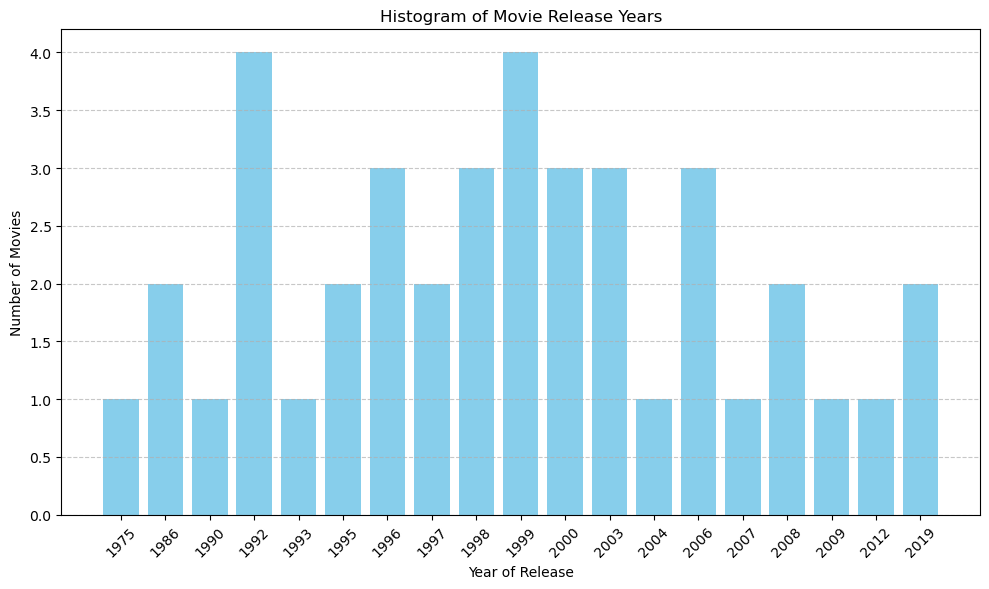

In [49]:
import matplotlib.pyplot as plt

histogram_query = """
MATCH (m:Movie)
WHERE EXISTS(m.released)
RETURN toString(m.released) AS Year, COUNT(*) AS MovieCount
ORDER BY Year
"""

result = graph.run(histogram_query).data()

years = [record["Year"] for record in result]
movie_counts = [record["MovieCount"] for record in result]

plt.figure(figsize=(10, 6))
plt.bar(years, movie_counts, color='skyblue')
plt.xlabel('Year of Release')
plt.ylabel('Number of Movies')
plt.title('Histogram of Movie Release Years')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

8: Who are the 10 actors with the most movie played in

In [50]:
query = """
MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
RETURN a.name AS Actor, COUNT(m) AS MovieCount
ORDER BY MovieCount DESC
LIMIT 10
"""

result = graph.run(query).data()

for record in result:
    print(record["Actor"], ":", record["MovieCount"])

Tom Hanks : 12
Keanu Reeves : 7
Meg Ryan : 5
Jack Nicholson : 5
Hugo Weaving : 5
Cuba Gooding Jr. : 4
Kevin Bacon : 3
Laurence Fishburne : 3
Carrie-Anne Moss : 3
Tom Cruise : 3


9: Delete every movie made by a director of your choosing

In [51]:
query = """
MATCH (d:Person {name: 'Clint Eastwood'})-[:DIRECTED]->(m:Movie)
RETURN m.title AS MovieTitle
"""

result = graph.run(query)

# Suppression des relations et des nœuds associés
for record in result:
    movie_title = record["MovieTitle"]
    delete_query = """
    MATCH (:Person {name: 'Clint Eastwood'})-[:DIRECTED]->(m:Movie {title: $movieTitle})
    DETACH DELETE m
    """
    graph.run(delete_query, movieTitle=movie_title)

10: Give some statistics that you find interesting.

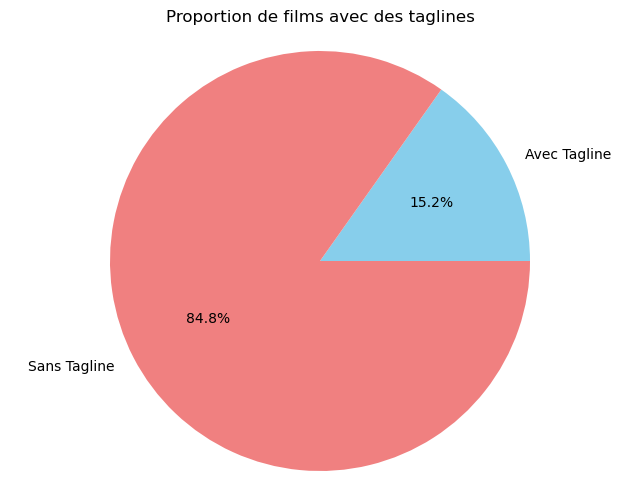

In [53]:
import matplotlib.pyplot as plt

# Requête Cypher pour récupérer les taglines des films
tagline_query = """
MATCH (m:Movie)
WHERE EXISTS(m.tagline)
RETURN COUNT(*) AS TaglineCount
"""

result = graph.run(tagline_query).data()

tagline_count = result[0]["TaglineCount"]

# Création d'un diagramme à secteurs pour visualiser la proportion de films avec des taglines
plt.figure(figsize=(8, 6))
plt.pie([tagline_count, 250 - tagline_count], labels=["Avec Tagline", "Sans Tagline"], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Proportion de films avec des taglines')
plt.axis('equal')
plt.show()

11: Sandbox exercise: think of a problematic and try to answer it.
Cherchons le nombre de réalisateurs qui ont aussi joué au mois une fois dans un de leur propre film.

In [72]:
# Requête Cypher pour trouver la proportion de directeurs ayant également joué dans leur propre film
proportion_query = """
MATCH (p:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(p)
WITH COUNT(DISTINCT p) AS directorsActed,
     SIZE((p)-[:DIRECTED]->(:Movie)) AS totalDirectors
RETURN directorsActed / totalDirectors AS proportion
"""

# Exécution de la requête et récupération du résultat
result = graph.run(proportion_query).evaluate()

# Affichage du résultat
print("La proportion de directeurs ayant également joué dans leur propre film est de :", result)

La proportion de directeurs ayant également joué dans leur propre film est de : 2


# Real World application 5

In [14]:
import pandas as pd
import tqdm
from py2neo import Graph

# Chemins d'accès aux fichiers CSV
nodes_csv_file = "C:/Users/celes/OneDrive/Documents/M1/S2/Infrastructures/NoSQL/data/Chap4/Homework_data/Twitch/FR_target.csv"
edges_csv_file = "C:/Users/celes/OneDrive/Documents/M1/S2/Infrastructures/NoSQL/data/Chap4/Homework_data/Twitch/FR_edges.csv"

# Connexion à Neo4j
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="Twitch")

# Suppression de toutes les données existantes dans la base de données
graph.delete_all()

# Création de la contrainte (si elle n'existe pas déjà)
try:
    graph.run("CREATE CONSTRAINT ON (n:TwitchUser) ASSERT n.user_id IS UNIQUE")
except:
    print("Constraint already exists")

# Chargement des données des nœuds à partir du fichier CSV
nodes_df = pd.read_csv(nodes_csv_file)

# Initialisation de la liste des transactions
transaction_list = []

# Itération sur chaque ligne du DataFrame pour créer les nœuds
for _, row in tqdm.tqdm(nodes_df.iterrows(), total=len(nodes_df)):
    node_data = {key: str(row[key]) for key in row.keys()}
    transaction_list.append(node_data)
    # Commit lorsque la liste atteint 1000 éléments
    if len(transaction_list) == 1000:
        graph.run("UNWIND $json AS data CREATE (n:TwitchUser) SET n = data", json=transaction_list)
        transaction_list = []

# Commit des transactions restantes
graph.run("UNWIND $json AS data CREATE (n:TwitchUser) SET n = data", json=transaction_list)

Constraint already exists


100%|██████████| 6551/6551 [00:01<00:00, 3638.92it/s]


(No data)

In [93]:
# edges
edges_df = pd.read_csv(edges_csv_file)

# Initialisation de la liste des transactions
transaction_list = []

# Itération sur chaque ligne du DataFrame pour créer les relations
for _, row in tqdm.tqdm(edges_df.iterrows(), total=len(edges_df)):
    from_node = str(row['from'])
    to_node = str(row['to'])
    transaction_list.append({"from": from_node, "to": to_node})
    # Commit lorsque la liste atteint 1000 éléments
    if len(transaction_list) == 1000:
        query = """
        UNWIND $json AS data
        MATCH (a:TwitchUser {user_id: data.from}), (b:TwitchUser {user_id: data.to})
        MERGE (a)-[:FOLLOWS]->(b)
        """
        graph.run(query, json=transaction_list)
        transaction_list = []

# Commit des transactions restantes
query = """
UNWIND $json AS data
MATCH (a:TwitchUser {user_id: data.from}), (b:TwitchUser {user_id: data.to})
MERGE (a)-[:FOLLOWS]->(b)
"""
graph.run(query, json=transaction_list)

100%|██████████| 112666/112666 [00:08<00:00, 13186.10it/s]


(No data)

J'ai eu beau tourner le code dans tous les sens, l'importation sur neo4j n'a pas fonctionné.

1: Give the IDs of the top 10 streamers that have atleast one collaboration.

In [ ]:
query = """
MATCH (u:TwitchUser)-[:INTERACTS]->(u2:TwitchUser)
WITH u, COUNT(u2) AS collaborations
WHERE collaborations > 0
RETURN u.user_id AS streamer_id, collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

results = graph.run(query)

for record in results:
    print(record["streamer_id"], record["collaborations"])

# Real World Application 6

In [24]:
import pandas as pd
from py2neo import Graph, Node

# Se connecter à Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stackoverflow")

# Chemin d'accès au fichier CSV contenant les nœuds
nodes_csv_file = "C:/Users/celes/OneDrive/Documents/M1/S2/Infrastructures/NoSQL/data/Chap4/Homework_data/stackoverflow_network/stack_network_nodes.csv"

# Lire le fichier CSV contenant les nœuds
nodes_df = pd.read_csv(nodes_csv_file)

# Créer les nœuds dans Neo4j
for index, row in nodes_df.iterrows():
    node = Node(row['name'], group=row['group'], nodesize=row['nodesize'])  # Assurez-vous d'adapter les noms de colonnes
    graph.create(node)

In [25]:
import pandas as pd
from py2neo import Graph

# Se connecter à Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stackoverflow")

# Chemin d'accès au fichier CSV contenant les relations
edges_csv_file = "C:/Users/celes/OneDrive/Documents/M1/S2/Infrastructures/NoSQL/data/Chap4/Homework_data/stackoverflow_network/stack_network_links.csv"

# Lire le fichier CSV contenant les relations
edges_df = pd.read_csv(edges_csv_file)

# Créer les relations dans Neo4j
for index, row in edges_df.iterrows():
    source = row['source']
    target = row['target']
    value = row['value']
    
    # Créer la relation dans Neo4j
    query = f"""
    MATCH (source {{ name: "{source}" }}), (target {{ name: "{target}" }})
    CREATE (source)-[:RELATION {{ value: {value} }}]->(target)
    """
    graph.run(query)

1: What are the 10 most popular keywords ?

In [18]:
import py2neo
from py2neo import Graph

# Se connecter à la base de données Neo4j
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="stackoverflow")

# Requête Cypher pour compter le nombre d'occurrences de chaque mot-clé
query = """
MATCH (n)
WHERE EXISTS(n.keywords)
UNWIND split(n.keywords, "|") AS keyword
RETURN keyword, count(*) AS popularity
ORDER BY popularity DESC
LIMIT 10
"""

# Exécuter la requête et récupérer les résultats
results = graph.run(query)

# Afficher les résultats
for record in results:
    print(record["keyword"], record["popularity"])